In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 51: XGBoost, use NAICS embeddings (mean encoding model)
XGBoost model, for NAICS use the embeddings from the mean encoding model

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path, PurePath

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_lift_curve
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Data

##### Embeddings

In [6]:
emb_df = pd.read_parquet(Path(PurePath(Path(setup.temp_path), '50_DATA_embeddings_menc')) \
                         .joinpath('50_emb_base.parquet'))
emb_cols = emb_df.columns
emb_df = emb_df.reset_index()
emb_df.head(2)

,LoanNr_ChkDgt,emb_00_NAICS,emb_00_NAICS_sector,emb_01_NAICS,emb_01_NAICS_sector,emb_02_NAICS,emb_02_NAICS_sector,emb_03_NAICS,emb_03_NAICS_sector,emb_04_NAICS,emb_04_NAICS_sector,emb_05_NAICS,emb_05_NAICS_sector,emb_06_NAICS,emb_06_NAICS_sector,emb_07_NAICS,emb_07_NAICS_sector
0,5282874009,-0.090746,-0.162568,-0.431420,-0.239123,-0.226072,-0.280463,0.123255,0.089394,0.245200,0.086713,-0.332046,-0.270013,-0.031899,0.096427,0.635116,0.708287
1,2568556001,-0.224277,-0.254972,-0.335808,-0.204232,-0.171521,-0.204713,0.170227,0.137785,0.533708,0.235135,-0.054817,-0.046233,0.111827,0.296616,0.618582,0.783837


##### Features Data

In [7]:
train_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_train.parquet')) \
    .merge(emb_df, on='LoanNr_ChkDgt')
print(train_df.shape)

(447252, 63)


In [8]:
test_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_test.parquet')) \
    .merge(emb_df, on='LoanNr_ChkDgt')
print(test_df.shape)

(144497, 63)


In [9]:
val_df = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_combined_base_val.parquet'))\
    .merge(emb_df, on='LoanNr_ChkDgt')
print(val_df.shape)

(96332, 63)


##### Set the predictor features.  

In [10]:
predictor_features = setup.predictor_features + list(emb_cols)
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'emb_00_NAICS', 'emb_00_NAICS_sector', 'emb_01_NAICS', 'emb_01_NAICS_sector', 'emb_02_NAICS', 'emb_02_NAICS_sector', 'emb_03_NAICS', 'emb_03_NAICS_sector', 'emb_04_NAICS', 'emb_04_NAICS_sector', 'emb_05_NAICS', 'emb_05_NAICS_sector', 'emb_06_NAICS', 'emb_06_NAICS_sector', 'emb_07_NAICS', 'emb_07_NAICS_sector']


In [11]:
with open(Path(setup.temp_path).joinpath('51_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Hyperparameter Tune and Fit

In [12]:
mean_target = np.mean(train_df['target'])
scale_pos_wt = (1-mean_target)/mean_target
print(f'target rate: {mean_target}, pos wt: {scale_pos_wt}')

target rate: 0.20301083058320588, pos wt: 3.9258455675848323


##### Do a simple hyperparameter search

In [13]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 10)

In [14]:
hyperparam_serarch = {'max_depth': [4, 5, 6],
                      'min_child_weight': [1, 10, 50],
                      'scale_pos_weight': list(np.linspace(1, scale_pos_wt, 3)),
                      'gamma': [0, 0.5, 1, 2],
                      'subsample': [0.5, 0.8, 1.0],
                      'learning_rate': [0.01, 0.1, 0.3],
                      'reg_alpha': [0, 0.001, 0.01, 0.1],
                      'reg_lambda': [0.001, 0.01, 0.1, 0.5]
                     }

In [15]:
# Set up a cross validation without the final fit; don't use early stopping yet
random_search = RandomizedSearchCV(xgb_model, hyperparam_serarch,
                                   n_iter=20, 
                                   n_jobs=-1,
                                   random_state=53,
                                   verbose = 0,
                                   refit = False)

In [16]:
# Do the cross validation parameter search
rs_fit = random_search.fit(train_df[predictor_features], train_df['target']);

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
print(random_search.best_params_)

{'subsample': 1.0, 'scale_pos_weight': 1.0, 'reg_lambda': 0.001, 'reg_alpha': 0.01, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 1}


In [18]:
pd.DataFrame({k:[random_search.best_params_[k]] for k in random_search.best_params_.keys()}) \
    .to_csv(Path(setup.temp_path).joinpath('51_REPORT_fit_parameter_selected.csv'), index=False)

##### Do a final fit with the full training data

In [19]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 20)

In [20]:
xgb_model = xgb_model.set_params(**random_search.best_params_)

In [21]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.48601	validation_1-logloss:0.48603
[1]	validation_0-logloss:0.47354	validation_1-logloss:0.47371
[2]	validation_0-logloss:0.46575	validation_1-logloss:0.46608
[3]	validation_0-logloss:0.46008	validation_1-logloss:0.46052
[4]	validation_0-logloss:0.45671	validation_1-logloss:0.45736
[5]	validation_0-logloss:0.45414	validation_1-logloss:0.45492
[6]	validation_0-logloss:0.45235	validation_1-logloss:0.45334
[7]	validation_0-logloss:0.45095	validation_1-logloss:0.45212
[8]	validation_0-logloss:0.45014	validation_1-logloss:0.45144
[9]	validation_0-logloss:0.44933	validation_1-logloss:0.45074
[10]	validation_0-logloss:0.44872	validation_1-logloss:0.45025
[11]	validation_0-logloss:0.44802	validation_1-logloss:0.44979
[12]	validation_0-logloss:0.44744	validation_1-logloss:0.44934
[13]	validation_0-logloss:0.44700	validation_1-logloss:0.44898
[14]	validation_0-logloss:0.44661	validation_1-logloss:0.44873
[15]	validation_0-logloss:0.44645	validation_1-logloss:0.44859
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
train_df['target'].value_counts()

target
0    356455
1     90797
Name: count, dtype: int64

##### Save the model

In [23]:
xgb_model.save_model(Path(setup.temp_path).joinpath('51_MODEL_xgboost.json'))

In [24]:
with open(Path(setup.temp_path).joinpath('51_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [25]:
pred_df = pd.concat([pd.DataFrame({'target': df['target'], 
                                          'predict_prob': xgb_model.predict_proba(df[predictor_features])[:,1]}) \
                            for df in [train_df, test_df, val_df]], 
                           keys = ['train', 'test', 'val'], names=['dset', 'index']) 

In [26]:
pred_df.groupby(['target'])['predict_prob'].agg(['mean', 'std'])

,mean,std
target,,
0,0.182097,0.119723
1,0.286186,0.113890


## Decision Threshold
Max f1, on training data

In [27]:
pred_train_df = pred_df[pred_df.index.get_level_values(0) == 'train']

In [28]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [29]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('51_REPORT_thresh_tune.csv'), index=False)

In [30]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(3)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.452997
11,0.22,0.452317
13,0.26,0.450231


##### Apply decision threshold
All datasets

In [31]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [32]:
pred_df['predict_bin'].value_counts()

predict_bin
0    405926
1    282155
Name: count, dtype: int64

In [33]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('51_DATA_combined_predictions.parquet'))

In [34]:
pred_df.head(10)

target  predict_prob  predict_bin
dset  index                                   
train 0           0      0.077735            0
      1           0      0.084974            0
      2           1      0.252981            1
      3           0      0.066715            0
      4           0      0.102765            0
      5           0      0.051519            0
      6           0      0.130398            0
      7           1      0.111070            0
      8           0      0.100572            0
      9           0      0.274761            1

## Metrics

In [35]:
pred_met_df = pred_df.copy().reset_index(level=0)

In [36]:
metrics_df = pd.concat([sg_plot.dset_metrics(pred_met_df[pred_met_df['dset'] == d]['target'], 
                                             pred_met_df[pred_met_df['dset'] == d]['predict_bin'], 
                                             pred_met_df[pred_met_df['dset'] == d]['predict_prob']) \
                        for d in ['train', 'val', 'test']], axis=1,
                      keys = ['train', 'val', 'test']) \
    .transpose()
metrics_df.to_csv(Path(setup.temp_path).joinpath('51_REPORT_metrics.csv'), index=True)
metrics_df

,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
train,0.664666,0.452997,0.338641,0.683965,0.392592,0.736097
val,0.659791,0.446823,0.333493,0.676826,0.384931,0.731453
test,0.663917,0.450738,0.337271,0.679257,0.385166,0.732365


## Lift
Test data

In [37]:
pred_test_df = pred_df[pred_df.index.get_level_values(0) == 'test']

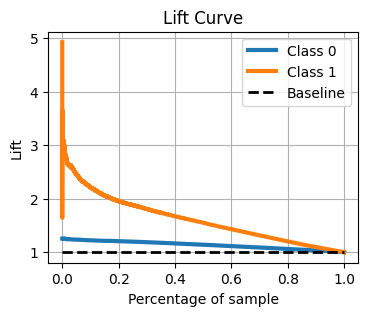

In [38]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('51_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [39]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [40]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('51_REPORT_importance_gain.csv'), index=True)

In [41]:
feat_impgain.head()

,importance
urban_flag,1044.345459
emb_06_NAICS,143.093735
LowDoc,140.538239
DisbursementGross,130.665741
emb_04_NAICS,50.246208


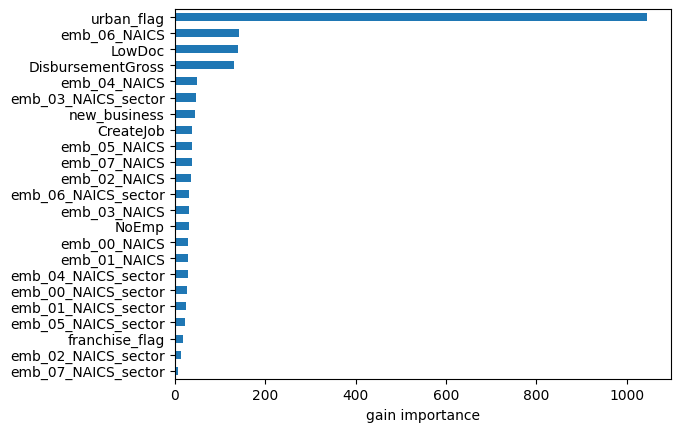

In [42]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('51_PLOT_importance_gain.png'))

##### Permutation Importance

In [43]:
perm_importance = permutation_importance(xgb_model, train_df[predictor_features], train_df['target'])

In [44]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [45]:
perm_importance_df.head(5)

,features,importance,abs_importance
9,emb_01_NAICS,0.003015,0.003015
3,DisbursementGross,0.002611,0.002611
1,CreateJob,0.001621,0.001621
19,emb_06_NAICS,0.001389,0.001389
15,emb_04_NAICS,0.001007,0.001007


In [46]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('51_DATA_importance_perturb.csv'),
            index=False)

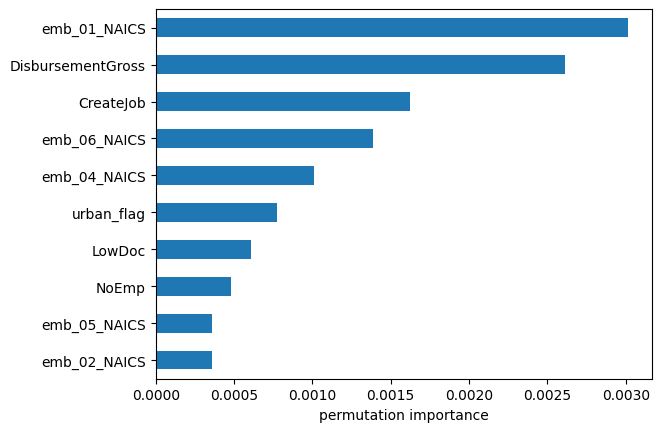

In [47]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('51_PLOT_importance_perturb.png'))